In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
import datetime as dt
from sklearn import metrics

In [2]:
def SIR(data,pop,gamma,rep_num,only_new_cases = False):
    
    beta = gamma * rep_num    
    new_cases = beta * data['susceptible'] * data['cases_active'] / pop
    
    if only_new_cases:
        return new_cases
    else:
        new_recovered = gamma * data['cases_active']
        
        susceptible = data['susceptible'] - new_cases
        cases = data['cases_active'] + new_cases - new_recovered
        recovered = data['recovered'] + new_recovered
        
        return susceptible,new_cases,rep_num,cases,new_recovered,recovered
        

def get_data(population,days_to_recovery):
    gamma = 1 / days_to_recovery
    
    df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv',
                          parse_dates = ['date'],index_col = ['date']).loc[:,['cases_new','cases_active']]
    
    df['recovered_new'] = (df['cases_new'] + df['cases_active'].shift(1) - df['cases_active']).fillna(0)
    df['recovered'] = df['recovered_new'].cumsum()
    growth_rate = ((df['cases_active'] - df['cases_active'].shift(1)) / df['cases_active'].shift(1)).fillna(0)
    df.insert(1,'reproduction_number',np.maximum(0,1 + (growth_rate / gamma)))
    df.insert(0,'susceptible',population - df['recovered'])
    df['cases_new_tomorrow'] = [int(SIR(df.loc[df.index[idx]],
                                        population,gamma,
                                        df.loc[df.index[idx],'reproduction_number'],
                                        only_new_cases = True)) for idx in range(len(df.index))]
    
    #Assume tomorrow's R value is the same as today
    df['r_error'] = df['reproduction_number'].shift(1) - df['reproduction_number']
    df['case_error'] = df['cases_new_tomorrow'].shift(1) - df['cases_new']
    
    return df.loc[df.index < '2022-11-01']

def calc_rmse(data):
    return np.sqrt((data ** 2).mean())

def set_sequence(size,data):
    x = []
    y = []
    
    for count in range(len(data) - size):
        window = [[s] for s in data[count : count + size]]
        label = data[count + size]
        
        x.append(window)
        y.append(label)
        
    return np.array(x),np.array(y)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [3]:
population = 33942526
df = get_data(population,7)

df

,susceptible,cases_new,reproduction_number,cases_active,recovered_new,recovered,cases_new_tomorrow,r_error,case_error
date,,,,,,,,,
2020-01-25,33942526.0,4,1.000000,4,0.0,0.0,0,NaN,NaN
2020-01-26,33942526.0,0,1.000000,4,0.0,0.0,0,0.000000,0.0
2020-01-27,33942526.0,0,1.000000,4,0.0,0.0,0,0.000000,0.0
2020-01-28,33942526.0,0,1.000000,4,0.0,0.0,0,0.000000,0.0
2020-01-29,33942526.0,3,6.250000,7,0.0,0.0,6,-5.250000,-3.0
...,...,...,...,...,...,...,...,...,...
2022-10-27,29080809.0,2762,1.382220,28720,1275.0,4861717.0,4858,-0.268592,950.0
2022-10-28,29078848.0,3296,1.325383,30055,1961.0,4863678.0,4875,0.056837,1562.0
2022-10-29,29076306.0,3189,1.150690,30702,2542.0,4866220.0,4323,0.174693,1686.0


In [4]:
TRAIN_SPLIT = int(0.8 * len(df.index))

train = df.loc[(df.index > df.index[0]) & (df.index < df.index[TRAIN_SPLIT]),'reproduction_number'].tolist()
test = df.loc[df.index >= df.index[TRAIN_SPLIT],'reproduction_number'].tolist()

In [5]:
base_check_df = df.loc[df.index >= df.index[TRAIN_SPLIT]]

a = {calc_rmse(base_check_df['r_error']),
     calc_rmse(base_check_df['case_error'])}

a

{0.17221587039101133, 1569.361904780838}

In [6]:
train = df.loc[(df.index > df.index[0]) & (df.index < df.index[TRAIN_SPLIT])]
test = df.loc[df.index >= df.index[TRAIN_SPLIT]]

In [7]:
model = {}
data = {}

TRAIN_SPLIT = int(0.8 * len(df.index))


for i in range(1,21):
    df = get_data(population,i)
    
    data[i] = {}
    data[i]['base'] = df
    data[i]['train_test'] = {}
    model[i] = {
        'base' : {
            'error' : {'R Error' :calc_rmse(df.loc[df.index >= df.index[TRAIN_SPLIT],'r_error']),
                       'Case Error' : calc_rmse(df.loc[df.index >= df.index[TRAIN_SPLIT],'case_error'])}
        },
        'model' : {'sequence_length' : {}},
        'test' : {}
    }
    
    print(f'Days to Recovery: {i}')
    
    if i == 1:
        best = {'Day' : i, 'Error' : model[i]['base']['error']}
        print(f'Current Best is Day {i}.')
    else:
        if best['Error']['Case Error'] > model[i]['base']['error']['Case Error']:
            best = {'Day' : i, 'Error' : model[i]['base']['error']}
            print(f'Current Best is Day {i}.')
    
    print(model[i]['base']['error'])
    
    print()

print(best)

Days to Recovery: 1
Current Best is Day 1.
{'R Error': 0.024602267198715912, 'Case Error': 32374.34764468188}

Days to Recovery: 2
Current Best is Day 2.
{'R Error': 0.049204534397431825, 'Case Error': 14185.292702971114}

Days to Recovery: 3
Current Best is Day 3.
{'R Error': 0.07380680159614772, 'Case Error': 8145.459275441856}

Days to Recovery: 4
Current Best is Day 4.
{'R Error': 0.0984090687948636, 'Case Error': 5152.941892051292}

Days to Recovery: 5
Current Best is Day 5.
{'R Error': 0.12301133599357954, 'Case Error': 3394.1299522859945}

Days to Recovery: 6
Current Best is Day 6.
{'R Error': 0.1476136031922954, 'Case Error': 2276.7537212858933}

Days to Recovery: 7
Current Best is Day 7.
{'R Error': 0.17221587039101133, 'Case Error': 1569.361904780838}

Days to Recovery: 8
Current Best is Day 8.
{'R Error': 0.19672574954380695, 'Case Error': 1186.9822625572867}

Days to Recovery: 9
Current Best is Day 9.
{'R Error': 0.22055150885890076, 'Case Error': 1081.0238441977763}

Days 

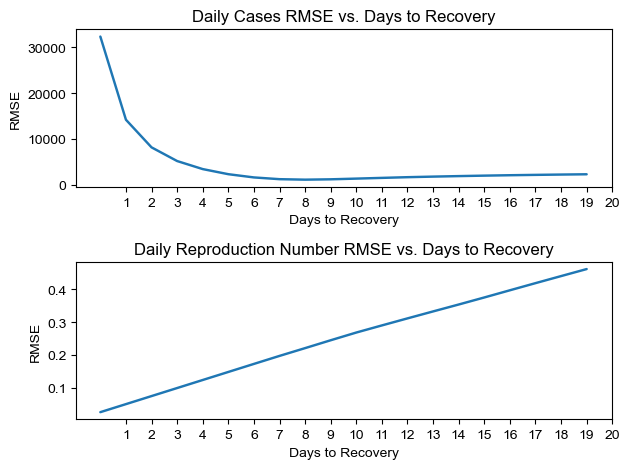

In [8]:
fig,(ax1,ax2) = plt.subplots(nrows = 2, ncols = 1)

plt.style.use('seaborn')
ax1.plot([model[i]['base']['error']['Case Error'] for i in model.keys()])
ax1.set_title('Daily Cases RMSE vs. Days to Recovery')
ax1.set_xlabel('Days to Recovery')
ax1.set_ylabel('RMSE')
ax1.set_xticks(range(1,21))

ax2.plot([model[i]['base']['error']['R Error'] for i in model.keys()])
ax2.set_title('Daily Reproduction Number RMSE vs. Days to Recovery')
ax2.set_xlabel('Days to Recovery')
ax2.set_ylabel('RMSE')
ax2.set_xticks(range(1,21))

fig.tight_layout()
plt.show()

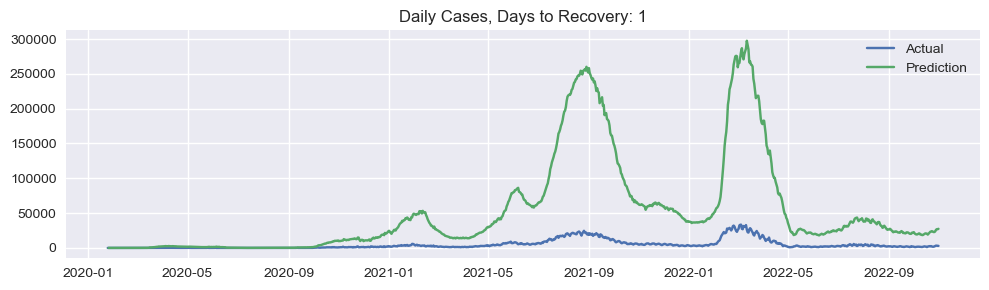

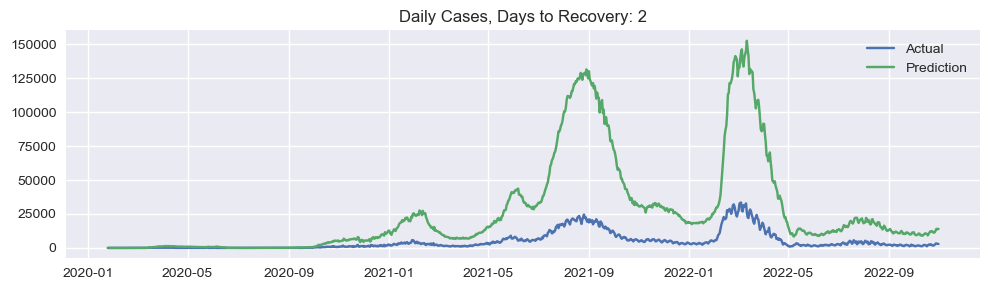

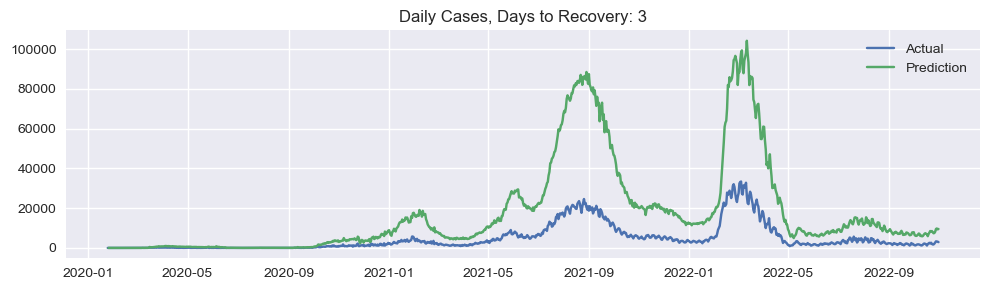

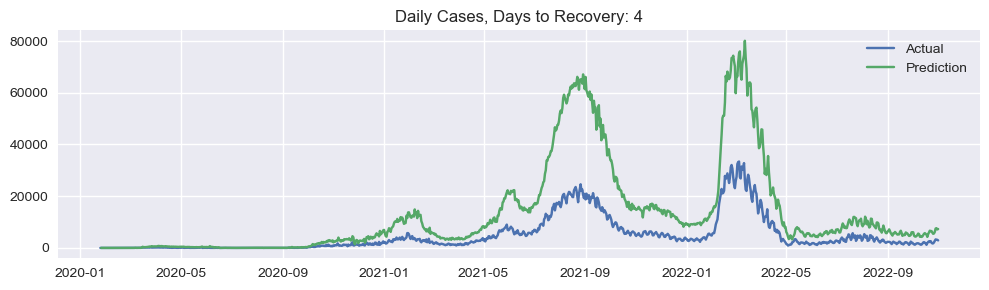

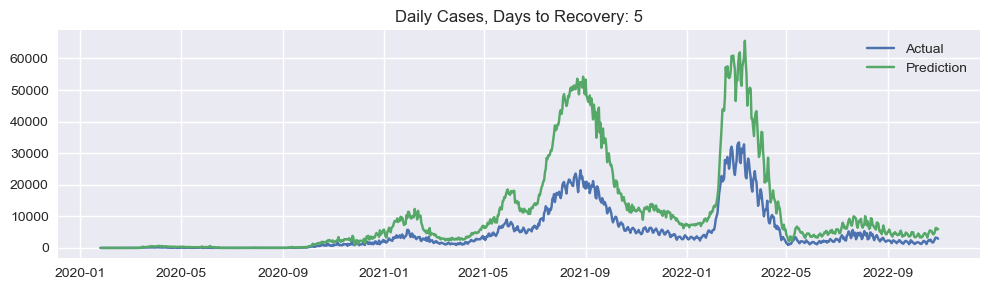

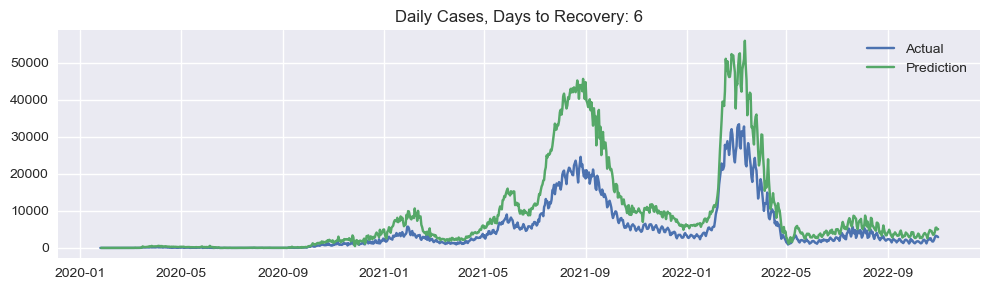

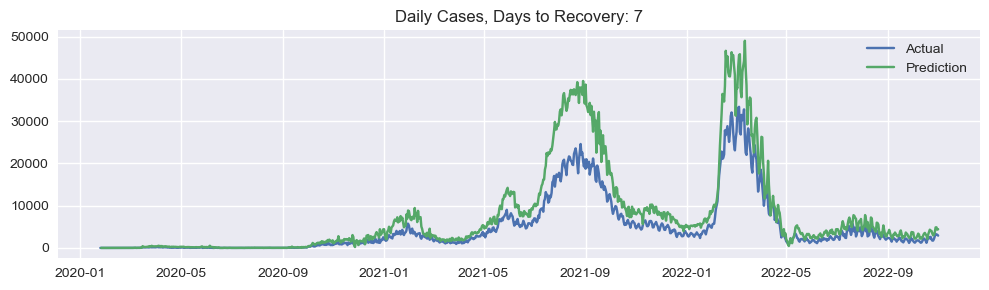

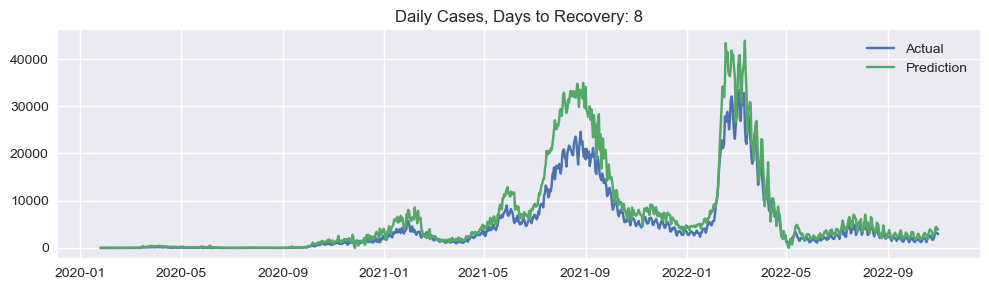

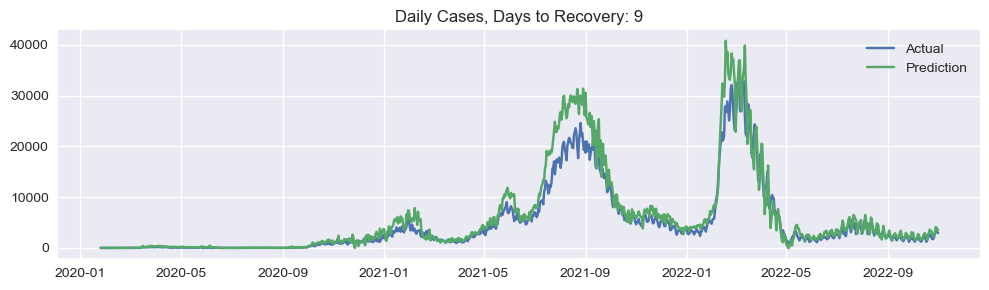

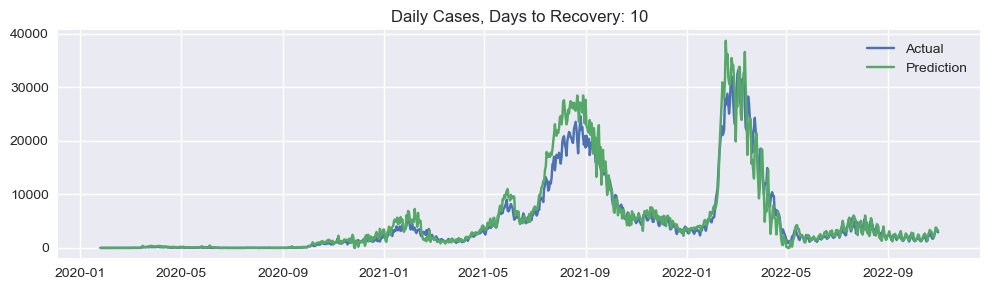

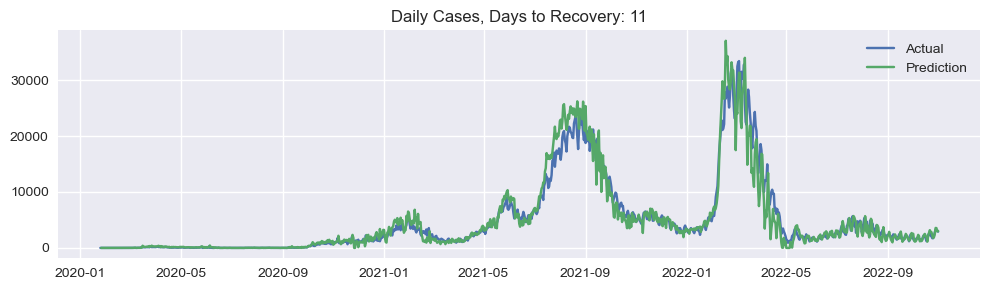

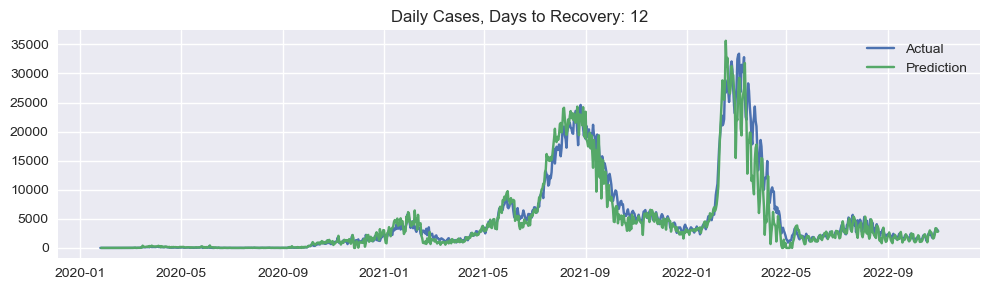

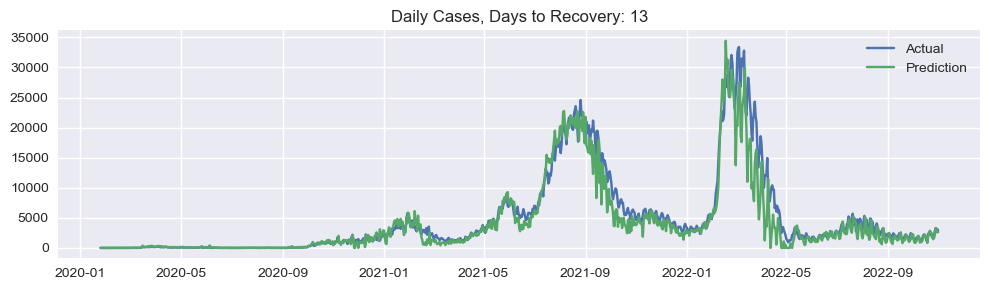

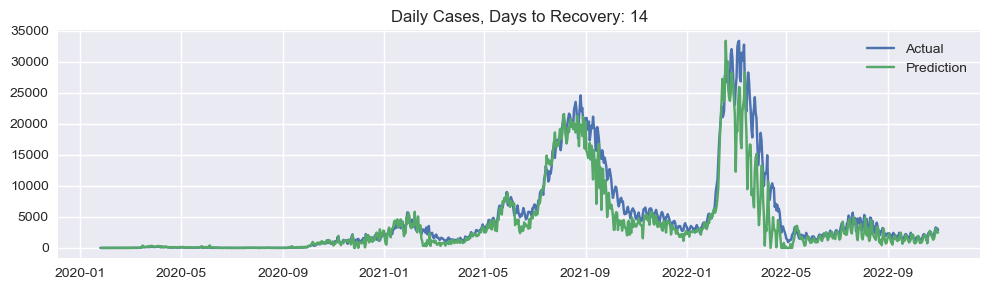

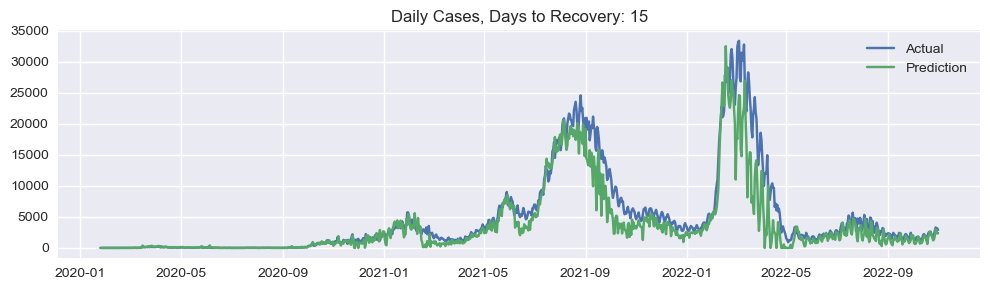

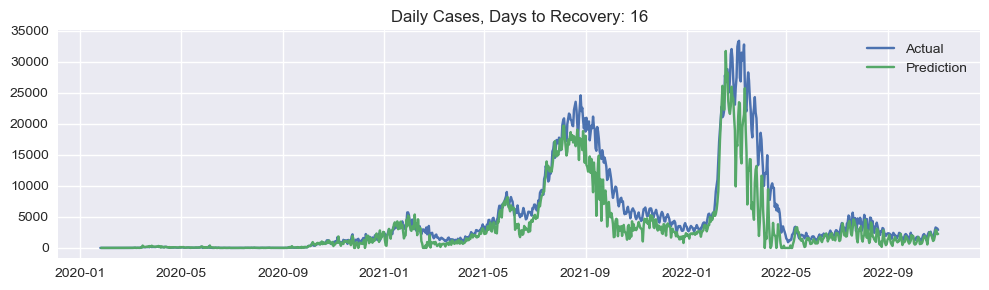

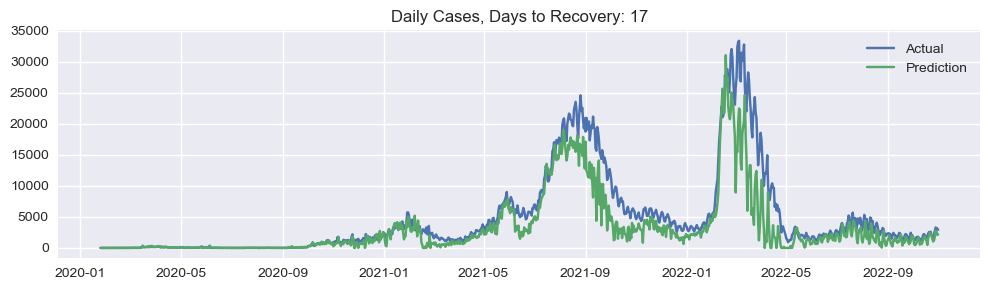

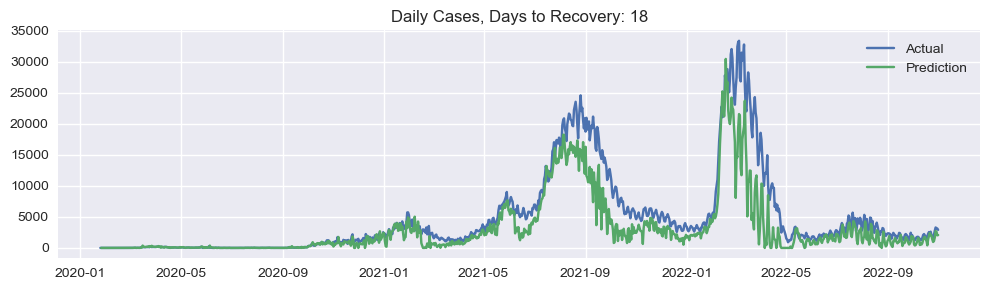

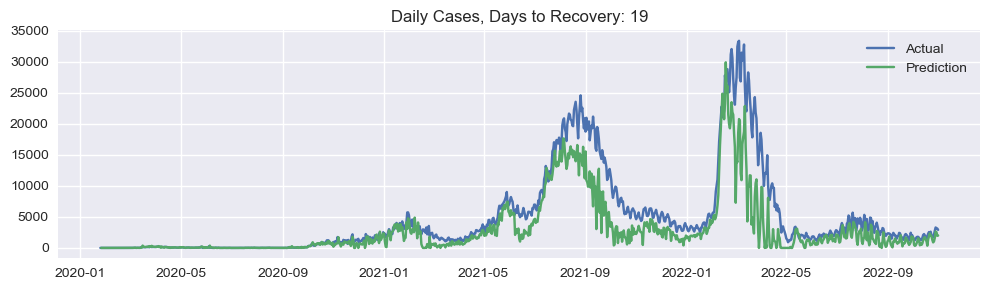

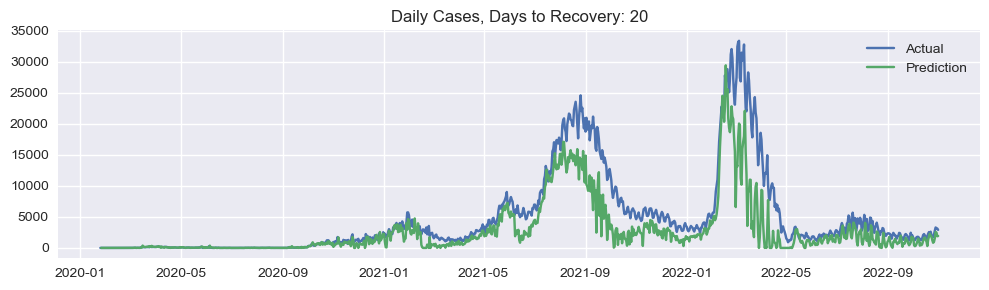

In [9]:
plt.style.use('seaborn')

for i in model.keys():
    plt.figure(figsize = (10,3))
    plt.title(f'Daily Cases, Days to Recovery: {i}')
    plt.plot(data[i]['base']['cases_new'])
    plt.plot(data[i]['base']['cases_new_tomorrow'].shift(1))
    plt.legend(['Actual','Prediction'])
    
#    ax2.set_title(f'Effective Reproduction Number, Days to Recovery: {i}')
#    ax2.plot(data[i]['reproduction_number'])
#    ax2.plot(data[i]['reproduction_number'].shift(1))
#    ax2.legend(['Actual','Prediction'])
    
    plt.tight_layout()
    plt.show()

In [13]:
days = 15
print("#########################################")
print(f'           Days to Recovery: {days}           ')
print("#########################################")

for seq_length in range(1,21):
    tf.random.set_seed(1)
    np.random.seed(1)

    data[days]['train_test'][seq_length] = {}

    train = data[days]['base'].loc[(data[days]['base'].index > data[days]['base'].index[0]) & 
                        (data[days]['base'].index < data[days]['base'].index[TRAIN_SPLIT - seq_length]),'reproduction_number'].tolist()
    test = data[days]['base'].loc[data[days]['base'].index >= data[days]['base'].index[TRAIN_SPLIT - seq_length],'reproduction_number'].tolist()

    data[days]['train_test'][seq_length]['train'] = train
    data[days]['train_test'][seq_length]['test'] = test

    print(f'Sequence Length: {seq_length}')

    x_train,y_train = set_sequence(seq_length,train)
    x_test,y_test = set_sequence(seq_length,test)

    input_shape = x_train.shape[1:]

    modelMake = build_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    modelMake.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4)
    )
    #model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, \
        restore_best_weights=True)]

    modelMake.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
    )

    modelMake.evaluate(x_test, y_test, verbose=1)

    modelMake.save(f'TRANSFORMER-{str(days).zfill(2)}-SEQLENGTH-{str(seq_length).zfill(2)}.h5')

    model[days]['model']['sequence_length'][seq_length] = modelMake

#########################################
           Days to Recovery: 15           
#########################################
Sequence Length: 1
Epoch 1/200
11/11 [==============================] - 9s 260ms/step - loss: 6.8809 - val_loss: 1.6692
Epoch 2/200
11/11 [==============================] - 2s 195ms/step - loss: 6.6526 - val_loss: 1.5930
Epoch 3/200
11/11 [==============================] - 3s 251ms/step - loss: 6.5336 - val_loss: 1.5284
Epoch 4/200
11/11 [==============================] - 3s 226ms/step - loss: 6.4493 - val_loss: 1.4797
Epoch 5/200
11/11 [==============================] - 2s 156ms/step - loss: 6.4175 - val_loss: 1.4396
Epoch 6/200
11/11 [==============================] - 3s 257ms/step - loss: 6.3391 - val_loss: 1.4051
Epoch 7/200
11/11 [==============================] - 3s 263ms/step - loss: 6.3076 - val_loss: 1.3695
Epoch 8/200
11/11 [==============================] - 3s 260ms/step - loss: 6.1623 - val_loss: 1.3336
Epoch 9/200
11/11 [===========================

11/11 [==============================] - 3s 224ms/step - loss: 7.2177 - val_loss: 1.7005
Epoch 4/200
11/11 [==============================] - 3s 230ms/step - loss: 7.2355 - val_loss: 1.6112
Epoch 5/200
11/11 [==============================] - 2s 196ms/step - loss: 7.1241 - val_loss: 1.5524
Epoch 6/200
11/11 [==============================] - 2s 192ms/step - loss: 7.3264 - val_loss: 1.5133
Epoch 7/200
11/11 [==============================] - 2s 204ms/step - loss: 6.6786 - val_loss: 1.4789
Epoch 8/200
11/11 [==============================] - 2s 227ms/step - loss: 6.6387 - val_loss: 1.4473
Epoch 9/200
11/11 [==============================] - 2s 186ms/step - loss: 6.8541 - val_loss: 1.4142
Epoch 10/200
11/11 [==============================] - 2s 215ms/step - loss: 6.5331 - val_loss: 1.3798
Epoch 11/200
11/11 [==============================] - 3s 230ms/step - loss: 6.3789 - val_loss: 1.3464
Epoch 12/200
11/11 [==============================] - 2s 230ms/step - loss: 6.4952 - val_loss: 1.3116

11/11 [==============================] - 2s 196ms/step - loss: 3.4810 - val_loss: 0.1048
Epoch 84/200
11/11 [==============================] - 2s 226ms/step - loss: 3.4159 - val_loss: 0.1061
Epoch 85/200
11/11 [==============================] - 2s 207ms/step - loss: 3.1597 - val_loss: 0.1069
Epoch 86/200
11/11 [==============================] - 2s 178ms/step - loss: 3.0492 - val_loss: 0.1079
Epoch 87/200
11/11 [==============================] - 3s 250ms/step - loss: 3.1287 - val_loss: 0.1106
Epoch 88/200
11/11 [==============================] - 2s 200ms/step - loss: 3.3676 - val_loss: 0.1090
Epoch 89/200
11/11 [==============================] - 2s 191ms/step - loss: 3.4972 - val_loss: 0.1063
Epoch 90/200
11/11 [==============================] - 2s 218ms/step - loss: 3.4101 - val_loss: 0.1046
Epoch 91/200
11/11 [==============================] - 2s 227ms/step - loss: 3.3047 - val_loss: 0.1033
Epoch 92/200
11/11 [==============================] - 3s 222ms/step - loss: 3.1352 - val_loss: 

Epoch 13/200
10/10 [==============================] - 2s 220ms/step - loss: 6.6271 - val_loss: 1.4950
Epoch 14/200
10/10 [==============================] - 2s 227ms/step - loss: 7.0279 - val_loss: 1.4569
Epoch 15/200
10/10 [==============================] - 3s 270ms/step - loss: 6.1781 - val_loss: 1.4215
Epoch 16/200
10/10 [==============================] - 3s 262ms/step - loss: 6.4280 - val_loss: 1.3863
Epoch 17/200
10/10 [==============================] - 2s 192ms/step - loss: 6.8359 - val_loss: 1.3541
Epoch 18/200
10/10 [==============================] - 2s 188ms/step - loss: 6.2798 - val_loss: 1.3215
Epoch 19/200
10/10 [==============================] - 2s 209ms/step - loss: 6.7671 - val_loss: 1.2902
Epoch 20/200
10/10 [==============================] - 2s 231ms/step - loss: 6.3105 - val_loss: 1.2594
Epoch 21/200
10/10 [==============================] - 2s 233ms/step - loss: 6.2867 - val_loss: 1.2295
Epoch 22/200
10/10 [==============================] - 2s 222ms/step - loss: 5.6887

10/10 [==============================] - 2s 225ms/step - loss: 3.2910 - val_loss: 0.1282
Epoch 94/200
10/10 [==============================] - 2s 185ms/step - loss: 3.1793 - val_loss: 0.1275
Epoch 95/200
10/10 [==============================] - 2s 218ms/step - loss: 3.5468 - val_loss: 0.1276
Epoch 96/200
10/10 [==============================] - 2s 204ms/step - loss: 2.8720 - val_loss: 0.1277
Epoch 97/200
10/10 [==============================] - 2s 221ms/step - loss: 3.1810 - val_loss: 0.1277
Epoch 98/200
10/10 [==============================] - 2s 223ms/step - loss: 2.9955 - val_loss: 0.1284
Epoch 99/200
10/10 [==============================] - 2s 173ms/step - loss: 3.8227 - val_loss: 0.1277
Epoch 100/200
10/10 [==============================] - 2s 200ms/step - loss: 3.1199 - val_loss: 0.1265
Epoch 101/200
10/10 [==============================] - 3s 257ms/step - loss: 3.4115 - val_loss: 0.1261
Epoch 102/200
10/10 [==============================] - 2s 199ms/step - loss: 3.2306 - val_los

10/10 [==============================] - 2s 212ms/step - loss: 2.8062 - val_loss: 0.1169
Epoch 173/200
10/10 [==============================] - 2s 237ms/step - loss: 3.1411 - val_loss: 0.1167
Epoch 174/200
10/10 [==============================] - 2s 208ms/step - loss: 3.1299 - val_loss: 0.1174
Epoch 175/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5137 - val_loss: 0.1172
Epoch 176/200
10/10 [==============================] - 2s 186ms/step - loss: 2.7410 - val_loss: 0.1169
Epoch 177/200
10/10 [==============================] - 2s 199ms/step - loss: 3.2967 - val_loss: 0.1169
Epoch 178/200
10/10 [==============================] - 2s 233ms/step - loss: 2.8915 - val_loss: 0.1174
Epoch 179/200
10/10 [==============================] - 2s 188ms/step - loss: 2.9273 - val_loss: 0.1169
Epoch 180/200
10/10 [==============================] - 2s 219ms/step - loss: 3.0842 - val_loss: 0.1165
Epoch 181/200
10/10 [==============================] - 3s 271ms/step - loss: 2.7614 - v

10/10 [==============================] - 2s 214ms/step - loss: 4.3272 - val_loss: 0.5776
Epoch 52/200
10/10 [==============================] - 3s 261ms/step - loss: 4.0206 - val_loss: 0.5751
Epoch 53/200
10/10 [==============================] - 2s 210ms/step - loss: 4.1193 - val_loss: 0.5723
Epoch 54/200
10/10 [==============================] - 2s 238ms/step - loss: 3.3736 - val_loss: 0.5704
Epoch 55/200
10/10 [==============================] - 3s 288ms/step - loss: 3.6357 - val_loss: 0.5691
Epoch 56/200
10/10 [==============================] - 3s 295ms/step - loss: 3.5795 - val_loss: 0.5665
Epoch 57/200
10/10 [==============================] - 3s 306ms/step - loss: 3.7779 - val_loss: 0.5644
Epoch 58/200
10/10 [==============================] - 3s 303ms/step - loss: 3.5803 - val_loss: 0.5628
Epoch 59/200
10/10 [==============================] - 3s 302ms/step - loss: 3.7838 - val_loss: 0.5605
Epoch 60/200
10/10 [==============================] - 3s 301ms/step - loss: 3.8829 - val_loss: 

10/10 [==============================] - 3s 259ms/step - loss: 3.1646 - val_loss: 0.1116
Epoch 132/200
10/10 [==============================] - 2s 209ms/step - loss: 2.7160 - val_loss: 0.1138
Epoch 133/200
10/10 [==============================] - 2s 240ms/step - loss: 3.1964 - val_loss: 0.1119
Epoch 134/200
10/10 [==============================] - 3s 260ms/step - loss: 3.1733 - val_loss: 0.1117
Epoch 135/200
10/10 [==============================] - 2s 194ms/step - loss: 2.7395 - val_loss: 0.1108
Epoch 136/200
10/10 [==============================] - 2s 217ms/step - loss: 3.1338 - val_loss: 0.1103
Epoch 137/200
10/10 [==============================] - 2s 230ms/step - loss: 2.7451 - val_loss: 0.1111
Epoch 138/200
10/10 [==============================] - 2s 248ms/step - loss: 3.0332 - val_loss: 0.1128
Epoch 139/200
10/10 [==============================] - 2s 220ms/step - loss: 2.5715 - val_loss: 0.1138
Epoch 140/200
10/10 [==============================] - 2s 198ms/step - loss: 2.8939 - v

10/10 [==============================] - 3s 284ms/step - loss: 3.8252 - val_loss: 0.1113
Epoch 65/200
10/10 [==============================] - 2s 233ms/step - loss: 2.9913 - val_loss: 0.1108
Epoch 66/200
10/10 [==============================] - 2s 225ms/step - loss: 3.2703 - val_loss: 0.1100
Epoch 67/200
10/10 [==============================] - 2s 228ms/step - loss: 3.4395 - val_loss: 0.1091
Epoch 68/200
10/10 [==============================] - 2s 241ms/step - loss: 4.6623 - val_loss: 0.1096
Epoch 69/200
10/10 [==============================] - 3s 258ms/step - loss: 3.4474 - val_loss: 0.1093
Epoch 70/200
10/10 [==============================] - 2s 211ms/step - loss: 3.6976 - val_loss: 0.1085
Epoch 71/200
10/10 [==============================] - 3s 281ms/step - loss: 3.9101 - val_loss: 0.1085
Epoch 72/200
10/10 [==============================] - 2s 245ms/step - loss: 3.3371 - val_loss: 0.1087
Epoch 73/200
10/10 [==============================] - 2s 218ms/step - loss: 3.6319 - val_loss: 

10/10 [==============================] - 3s 300ms/step - loss: 3.0572 - val_loss: 0.0875
Epoch 42/200
10/10 [==============================] - 3s 257ms/step - loss: 3.7427 - val_loss: 0.0863
Epoch 43/200
10/10 [==============================] - 2s 244ms/step - loss: 3.1839 - val_loss: 0.0848
Epoch 44/200
10/10 [==============================] - 2s 250ms/step - loss: 3.1751 - val_loss: 0.0850
Epoch 45/200
10/10 [==============================] - 3s 250ms/step - loss: 2.9003 - val_loss: 0.0860
Epoch 46/200
10/10 [==============================] - 2s 253ms/step - loss: 2.7168 - val_loss: 0.0845
Epoch 47/200
10/10 [==============================] - 3s 287ms/step - loss: 3.4431 - val_loss: 0.0850
Epoch 48/200
10/10 [==============================] - 3s 315ms/step - loss: 3.0568 - val_loss: 0.0834
Epoch 49/200
10/10 [==============================] - 3s 317ms/step - loss: 3.3413 - val_loss: 0.0824
Epoch 50/200
10/10 [==============================] - 3s 309ms/step - loss: 3.1367 - val_loss: 

10/10 [==============================] - 2s 221ms/step - loss: 2.9101 - val_loss: 0.1050
Epoch 35/200
10/10 [==============================] - 2s 210ms/step - loss: 3.6104 - val_loss: 0.1040
Epoch 36/200
10/10 [==============================] - 3s 278ms/step - loss: 3.4314 - val_loss: 0.1048
Epoch 37/200
10/10 [==============================] - 2s 191ms/step - loss: 4.1114 - val_loss: 0.1051
Epoch 38/200
10/10 [==============================] - 2s 228ms/step - loss: 3.3895 - val_loss: 0.1028
Epoch 39/200
10/10 [==============================] - 2s 217ms/step - loss: 3.2122 - val_loss: 0.1015
Epoch 40/200
10/10 [==============================] - 3s 260ms/step - loss: 3.6759 - val_loss: 0.1005
Epoch 41/200
10/10 [==============================] - 2s 246ms/step - loss: 3.1906 - val_loss: 0.0997
Epoch 42/200
10/10 [==============================] - 3s 255ms/step - loss: 3.6482 - val_loss: 0.0988
Epoch 43/200
10/10 [==============================] - 3s 274ms/step - loss: 4.1072 - val_loss: 

10/10 [==============================] - 3s 347ms/step - loss: 2.8640 - val_loss: 0.0847
Epoch 115/200
10/10 [==============================] - 3s 243ms/step - loss: 3.0613 - val_loss: 0.0849
Epoch 116/200
10/10 [==============================] - 3s 298ms/step - loss: 3.1717 - val_loss: 0.0853
Epoch 117/200
10/10 [==============================] - 3s 249ms/step - loss: 3.2782 - val_loss: 0.0858
Epoch 118/200
10/10 [==============================] - 2s 237ms/step - loss: 3.0528 - val_loss: 0.0854
Epoch 119/200
10/10 [==============================] - 2s 252ms/step - loss: 2.8170 - val_loss: 0.0852
Epoch 120/200
10/10 [==============================] - 3s 262ms/step - loss: 3.2721 - val_loss: 0.0848
Epoch 121/200
7/7 [==============================] - 0s 12ms/step - loss: 0.1790
Sequence Length: 9
Epoch 1/200
10/10 [==============================] - 10s 404ms/step - loss: 10.3915 - val_loss: 2.4098
Epoch 2/200
10/10 [==============================] - 3s 294ms/step - loss: 8.8691 - val_lo

10/10 [==============================] - 3s 267ms/step - loss: 3.6276 - val_loss: 0.1022
Epoch 73/200
10/10 [==============================] - 3s 275ms/step - loss: 3.3487 - val_loss: 0.1021
Epoch 74/200
10/10 [==============================] - 2s 223ms/step - loss: 3.2953 - val_loss: 0.1020
Epoch 75/200
10/10 [==============================] - 3s 278ms/step - loss: 3.3272 - val_loss: 0.1019
Epoch 76/200
10/10 [==============================] - 3s 260ms/step - loss: 3.1138 - val_loss: 0.1028
Epoch 77/200
10/10 [==============================] - 3s 287ms/step - loss: 3.2872 - val_loss: 0.1020
Epoch 78/200
10/10 [==============================] - 3s 304ms/step - loss: 3.4521 - val_loss: 0.1012
Epoch 79/200
10/10 [==============================] - 2s 204ms/step - loss: 3.7603 - val_loss: 0.1012
Epoch 80/200
10/10 [==============================] - 2s 235ms/step - loss: 3.9342 - val_loss: 0.1023
Epoch 81/200
10/10 [==============================] - 3s 256ms/step - loss: 3.4727 - val_loss: 

10/10 [==============================] - 3s 292ms/step - loss: 3.5403 - val_loss: 0.1447
Epoch 22/200
10/10 [==============================] - 3s 260ms/step - loss: 3.9816 - val_loss: 0.1371
Epoch 23/200
10/10 [==============================] - 2s 245ms/step - loss: 3.8591 - val_loss: 0.1333
Epoch 24/200
10/10 [==============================] - 2s 231ms/step - loss: 3.2516 - val_loss: 0.1310
Epoch 25/200
10/10 [==============================] - 3s 281ms/step - loss: 3.7285 - val_loss: 0.1280
Epoch 26/200
10/10 [==============================] - 3s 295ms/step - loss: 3.7546 - val_loss: 0.1261
Epoch 27/200
10/10 [==============================] - 3s 319ms/step - loss: 3.5975 - val_loss: 0.1235
Epoch 28/200
10/10 [==============================] - 3s 323ms/step - loss: 3.2728 - val_loss: 0.1224
Epoch 29/200
10/10 [==============================] - 3s 301ms/step - loss: 3.7034 - val_loss: 0.1218
Epoch 30/200
10/10 [==============================] - 3s 307ms/step - loss: 3.3932 - val_loss: 

10/10 [==============================] - 3s 299ms/step - loss: 3.9324 - val_loss: 0.1142
Epoch 30/200
10/10 [==============================] - 3s 258ms/step - loss: 3.7603 - val_loss: 0.1135
Epoch 31/200
10/10 [==============================] - 3s 264ms/step - loss: 4.5016 - val_loss: 0.1130
Epoch 32/200
10/10 [==============================] - 2s 215ms/step - loss: 4.0901 - val_loss: 0.1118
Epoch 33/200
10/10 [==============================] - 2s 236ms/step - loss: 4.0637 - val_loss: 0.1111
Epoch 34/200
10/10 [==============================] - 3s 256ms/step - loss: 3.7344 - val_loss: 0.1109
Epoch 35/200
10/10 [==============================] - 3s 261ms/step - loss: 4.3402 - val_loss: 0.1114
Epoch 36/200
10/10 [==============================] - 3s 274ms/step - loss: 4.1154 - val_loss: 0.1121
Epoch 37/200
10/10 [==============================] - 2s 254ms/step - loss: 3.8543 - val_loss: 0.1097
Epoch 38/200
10/10 [==============================] - 3s 277ms/step - loss: 3.4993 - val_loss: 

10/10 [==============================] - 3s 309ms/step - loss: 4.3345 - val_loss: 0.1259
Epoch 29/200
10/10 [==============================] - 3s 287ms/step - loss: 4.1219 - val_loss: 0.1248
Epoch 30/200
10/10 [==============================] - 2s 208ms/step - loss: 3.9760 - val_loss: 0.1260
Epoch 31/200
10/10 [==============================] - 3s 275ms/step - loss: 4.7470 - val_loss: 0.1263
Epoch 32/200
10/10 [==============================] - 3s 264ms/step - loss: 4.3632 - val_loss: 0.1260
Epoch 33/200
10/10 [==============================] - 3s 268ms/step - loss: 3.9524 - val_loss: 0.1253
Epoch 34/200
10/10 [==============================] - 3s 337ms/step - loss: 4.3607 - val_loss: 0.1243
Epoch 35/200
10/10 [==============================] - 3s 242ms/step - loss: 4.2372 - val_loss: 0.1206
Epoch 36/200
10/10 [==============================] - 3s 275ms/step - loss: 3.6200 - val_loss: 0.1190
Epoch 37/200
10/10 [==============================] - 3s 284ms/step - loss: 3.7866 - val_loss: 

10/10 [==============================] - 3s 283ms/step - loss: 3.4779 - val_loss: 0.0964
Epoch 109/200
10/10 [==============================] - 3s 307ms/step - loss: 3.0172 - val_loss: 0.0964
Epoch 110/200
10/10 [==============================] - 3s 270ms/step - loss: 3.1110 - val_loss: 0.0961
Epoch 111/200
10/10 [==============================] - 3s 292ms/step - loss: 3.1898 - val_loss: 0.0962
Epoch 112/200
10/10 [==============================] - 3s 262ms/step - loss: 3.1466 - val_loss: 0.0964
Epoch 113/200
10/10 [==============================] - 3s 284ms/step - loss: 3.0509 - val_loss: 0.0960
Epoch 114/200
10/10 [==============================] - 3s 312ms/step - loss: 3.1501 - val_loss: 0.0966
Epoch 115/200
10/10 [==============================] - 3s 284ms/step - loss: 3.1699 - val_loss: 0.0988
Epoch 116/200
10/10 [==============================] - 3s 278ms/step - loss: 3.3263 - val_loss: 0.0972
Epoch 117/200
10/10 [==============================] - 3s 247ms/step - loss: 3.1927 - v

10/10 [==============================] - 4s 387ms/step - loss: 3.4065 - val_loss: 0.1011
Epoch 61/200
10/10 [==============================] - 4s 377ms/step - loss: 3.6657 - val_loss: 0.0998
Epoch 62/200
10/10 [==============================] - 4s 430ms/step - loss: 3.4176 - val_loss: 0.0990
Epoch 63/200
10/10 [==============================] - 4s 421ms/step - loss: 3.4386 - val_loss: 0.0979
Epoch 64/200
10/10 [==============================] - 4s 398ms/step - loss: 3.5512 - val_loss: 0.0981
Epoch 65/200
10/10 [==============================] - 4s 389ms/step - loss: 3.2414 - val_loss: 0.0969
Epoch 66/200
10/10 [==============================] - 4s 397ms/step - loss: 3.4958 - val_loss: 0.0967
Epoch 67/200
10/10 [==============================] - 4s 375ms/step - loss: 3.1967 - val_loss: 0.0966
Epoch 68/200
10/10 [==============================] - 4s 393ms/step - loss: 3.4901 - val_loss: 0.0955
Epoch 69/200
10/10 [==============================] - 3s 367ms/step - loss: 3.3496 - val_loss: 

10/10 [==============================] - 4s 412ms/step - loss: 2.8746 - val_loss: 0.0836
Epoch 141/200
10/10 [==============================] - 4s 424ms/step - loss: 3.0586 - val_loss: 0.0833
Epoch 142/200
10/10 [==============================] - 4s 413ms/step - loss: 2.8571 - val_loss: 0.0838
Epoch 143/200
10/10 [==============================] - 4s 407ms/step - loss: 2.6144 - val_loss: 0.0868
Epoch 144/200
10/10 [==============================] - 4s 402ms/step - loss: 2.9190 - val_loss: 0.0902
Epoch 145/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1605
Sequence Length: 14
Epoch 1/200
10/10 [==============================] - 10s 452ms/step - loss: 11.1352 - val_loss: 2.4183
Epoch 2/200
10/10 [==============================] - 3s 335ms/step - loss: 8.4432 - val_loss: 2.0454
Epoch 3/200
10/10 [==============================] - 3s 330ms/step - loss: 8.4447 - val_loss: 1.7829
Epoch 4/200
10/10 [==============================] - 4s 362ms/step - loss: 9.4824 - val_loss:

10/10 [==============================] - 3s 315ms/step - loss: 3.1844 - val_loss: 0.0844
Epoch 75/200
10/10 [==============================] - 3s 278ms/step - loss: 3.7947 - val_loss: 0.0846
Epoch 76/200
10/10 [==============================] - 3s 288ms/step - loss: 3.7784 - val_loss: 0.0870
Epoch 77/200
10/10 [==============================] - 3s 333ms/step - loss: 3.4271 - val_loss: 0.0855
Epoch 78/200
10/10 [==============================] - 3s 322ms/step - loss: 3.4390 - val_loss: 0.0833
Epoch 79/200
10/10 [==============================] - 3s 307ms/step - loss: 3.8339 - val_loss: 0.0837
Epoch 80/200
10/10 [==============================] - 3s 325ms/step - loss: 3.1218 - val_loss: 0.0849
Epoch 81/200
10/10 [==============================] - 3s 310ms/step - loss: 3.2912 - val_loss: 0.0834
Epoch 82/200
10/10 [==============================] - 3s 266ms/step - loss: 3.4532 - val_loss: 0.0819
Epoch 83/200
10/10 [==============================] - 3s 323ms/step - loss: 3.3730 - val_loss: 

10/10 [==============================] - 4s 357ms/step - loss: 4.2952 - val_loss: 0.1719
Epoch 25/200
10/10 [==============================] - 3s 333ms/step - loss: 4.9027 - val_loss: 0.1679
Epoch 26/200
10/10 [==============================] - 3s 269ms/step - loss: 4.2877 - val_loss: 0.1608
Epoch 27/200
10/10 [==============================] - 4s 363ms/step - loss: 3.9149 - val_loss: 0.1566
Epoch 28/200
10/10 [==============================] - 3s 331ms/step - loss: 4.0019 - val_loss: 0.1550
Epoch 29/200
10/10 [==============================] - 3s 287ms/step - loss: 3.6921 - val_loss: 0.1518
Epoch 30/200
10/10 [==============================] - 3s 304ms/step - loss: 3.9193 - val_loss: 0.1500
Epoch 31/200
10/10 [==============================] - 3s 316ms/step - loss: 3.4524 - val_loss: 0.1492
Epoch 32/200
10/10 [==============================] - 3s 335ms/step - loss: 3.3527 - val_loss: 0.1475
Epoch 33/200
10/10 [==============================] - 2s 256ms/step - loss: 4.1435 - val_loss: 

10/10 [==============================] - 3s 316ms/step - loss: 2.9903 - val_loss: 0.0984
Epoch 105/200
10/10 [==============================] - 3s 249ms/step - loss: 2.8622 - val_loss: 0.0977
Epoch 106/200
10/10 [==============================] - 3s 329ms/step - loss: 2.8261 - val_loss: 0.0978
Epoch 107/200
10/10 [==============================] - 3s 299ms/step - loss: 2.9417 - val_loss: 0.0973
Epoch 108/200
10/10 [==============================] - 3s 278ms/step - loss: 3.0707 - val_loss: 0.0962
Epoch 109/200
10/10 [==============================] - 4s 387ms/step - loss: 2.8324 - val_loss: 0.0952
Epoch 110/200
10/10 [==============================] - 3s 297ms/step - loss: 2.8691 - val_loss: 0.0951
Epoch 111/200
10/10 [==============================] - 3s 274ms/step - loss: 3.0065 - val_loss: 0.0971
Epoch 112/200
10/10 [==============================] - 3s 301ms/step - loss: 3.3025 - val_loss: 0.0977
Epoch 113/200
10/10 [==============================] - 4s 350ms/step - loss: 2.7193 - v

10/10 [==============================] - 4s 385ms/step - loss: 4.0603 - val_loss: 0.1553
Epoch 52/200
10/10 [==============================] - 4s 403ms/step - loss: 4.3749 - val_loss: 0.1500
Epoch 53/200
10/10 [==============================] - 4s 369ms/step - loss: 3.9052 - val_loss: 0.1491
Epoch 54/200
10/10 [==============================] - 4s 401ms/step - loss: 4.5651 - val_loss: 0.1429
Epoch 55/200
10/10 [==============================] - 4s 390ms/step - loss: 4.2626 - val_loss: 0.1394
Epoch 56/200
10/10 [==============================] - 4s 382ms/step - loss: 4.2476 - val_loss: 0.1388
Epoch 57/200
10/10 [==============================] - 4s 400ms/step - loss: 4.2940 - val_loss: 0.1389
Epoch 58/200
10/10 [==============================] - 4s 357ms/step - loss: 4.4739 - val_loss: 0.1361
Epoch 59/200
10/10 [==============================] - 4s 388ms/step - loss: 4.5753 - val_loss: 0.1350
Epoch 60/200
10/10 [==============================] - 4s 390ms/step - loss: 3.8562 - val_loss: 

10/10 [==============================] - 4s 383ms/step - loss: 3.2076 - val_loss: 0.1004
Epoch 132/200
10/10 [==============================] - 4s 370ms/step - loss: 3.3990 - val_loss: 0.0994
Epoch 133/200
10/10 [==============================] - 3s 328ms/step - loss: 2.9401 - val_loss: 0.0990
Epoch 134/200
10/10 [==============================] - 4s 353ms/step - loss: 3.5550 - val_loss: 0.0967
Epoch 135/200
10/10 [==============================] - 3s 331ms/step - loss: 2.8015 - val_loss: 0.0953
Epoch 136/200
10/10 [==============================] - 3s 327ms/step - loss: 3.5876 - val_loss: 0.0999
Epoch 137/200
10/10 [==============================] - 4s 370ms/step - loss: 3.2973 - val_loss: 0.1019
Epoch 138/200
10/10 [==============================] - 4s 377ms/step - loss: 2.8623 - val_loss: 0.1019
Epoch 139/200
10/10 [==============================] - 3s 284ms/step - loss: 3.4378 - val_loss: 0.1034
Epoch 140/200
10/10 [==============================] - 3s 359ms/step - loss: 3.2760 - v

10/10 [==============================] - 4s 365ms/step - loss: 3.5275 - val_loss: 0.1045
Epoch 66/200
10/10 [==============================] - 4s 354ms/step - loss: 3.1106 - val_loss: 0.1033
Epoch 67/200
10/10 [==============================] - 3s 303ms/step - loss: 3.0684 - val_loss: 0.1033
Epoch 68/200
10/10 [==============================] - 3s 301ms/step - loss: 3.4997 - val_loss: 0.1079
Epoch 69/200
10/10 [==============================] - 4s 354ms/step - loss: 3.4676 - val_loss: 0.1067
Epoch 70/200
10/10 [==============================] - 3s 329ms/step - loss: 3.3303 - val_loss: 0.1043
Epoch 71/200
10/10 [==============================] - 4s 354ms/step - loss: 3.1169 - val_loss: 0.1049
Epoch 72/200
10/10 [==============================] - 3s 324ms/step - loss: 3.2541 - val_loss: 0.1022
Epoch 73/200
10/10 [==============================] - 3s 299ms/step - loss: 3.3736 - val_loss: 0.0995
Epoch 74/200
10/10 [==============================] - 4s 366ms/step - loss: 3.2197 - val_loss: 

10/10 [==============================] - 4s 458ms/step - loss: 4.6942 - val_loss: 0.3855
Epoch 20/200
10/10 [==============================] - 5s 455ms/step - loss: 4.4927 - val_loss: 0.3364
Epoch 21/200
10/10 [==============================] - 4s 415ms/step - loss: 5.0283 - val_loss: 0.2875
Epoch 22/200
10/10 [==============================] - 4s 372ms/step - loss: 4.5788 - val_loss: 0.2546
Epoch 23/200
10/10 [==============================] - 3s 292ms/step - loss: 4.2047 - val_loss: 0.2333
Epoch 24/200
10/10 [==============================] - 3s 323ms/step - loss: 4.9193 - val_loss: 0.2198
Epoch 25/200
10/10 [==============================] - 3s 308ms/step - loss: 4.5678 - val_loss: 0.2075
Epoch 26/200
10/10 [==============================] - 4s 366ms/step - loss: 4.7420 - val_loss: 0.1986
Epoch 27/200
10/10 [==============================] - 3s 328ms/step - loss: 4.4326 - val_loss: 0.1917
Epoch 28/200
10/10 [==============================] - 3s 331ms/step - loss: 4.1710 - val_loss: 

10/10 [==============================] - 4s 352ms/step - loss: 2.8129 - val_loss: 0.1153
Epoch 100/200
10/10 [==============================] - 4s 363ms/step - loss: 3.0431 - val_loss: 0.1158
Epoch 101/200
10/10 [==============================] - 3s 317ms/step - loss: 3.3148 - val_loss: 0.1159
Epoch 102/200
10/10 [==============================] - 4s 370ms/step - loss: 3.2819 - val_loss: 0.1135
Epoch 103/200
10/10 [==============================] - 4s 406ms/step - loss: 3.3179 - val_loss: 0.1149
Epoch 104/200
10/10 [==============================] - 4s 374ms/step - loss: 2.9791 - val_loss: 0.1106
Epoch 105/200
10/10 [==============================] - 3s 314ms/step - loss: 3.2782 - val_loss: 0.1080
Epoch 106/200
10/10 [==============================] - 4s 388ms/step - loss: 3.4500 - val_loss: 0.1094
Epoch 107/200
10/10 [==============================] - 4s 361ms/step - loss: 2.9865 - val_loss: 0.1087
Epoch 108/200
10/10 [==============================] - 4s 356ms/step - loss: 3.4282 - v

10/10 [==============================] - 4s 362ms/step - loss: 2.7537 - val_loss: 0.0935
Epoch 179/200
10/10 [==============================] - 3s 311ms/step - loss: 2.7713 - val_loss: 0.0942
Epoch 180/200
10/10 [==============================] - 4s 374ms/step - loss: 2.7487 - val_loss: 0.0944
Epoch 181/200
10/10 [==============================] - 4s 364ms/step - loss: 2.6507 - val_loss: 0.0964
Epoch 182/200
10/10 [==============================] - 4s 369ms/step - loss: 2.7155 - val_loss: 0.0976
Epoch 183/200
10/10 [==============================] - 4s 404ms/step - loss: 2.3861 - val_loss: 0.0989
Epoch 184/200
10/10 [==============================] - 3s 324ms/step - loss: 2.7418 - val_loss: 0.0956
Epoch 185/200
10/10 [==============================] - 4s 399ms/step - loss: 2.7049 - val_loss: 0.0957
Epoch 186/200
10/10 [==============================] - 3s 349ms/step - loss: 2.7197 - val_loss: 0.0946
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1760
Sequen

10/10 [==============================] - 3s 307ms/step - loss: 4.3228 - val_loss: 0.1206
Epoch 71/200
10/10 [==============================] - 3s 318ms/step - loss: 3.7109 - val_loss: 0.1197
Epoch 72/200
10/10 [==============================] - 3s 322ms/step - loss: 4.1251 - val_loss: 0.1178
Epoch 73/200
10/10 [==============================] - 3s 347ms/step - loss: 4.0030 - val_loss: 0.1161
Epoch 74/200
10/10 [==============================] - 3s 322ms/step - loss: 3.5213 - val_loss: 0.1161
Epoch 75/200
10/10 [==============================] - 3s 339ms/step - loss: 3.2366 - val_loss: 0.1139
Epoch 76/200
10/10 [==============================] - 4s 367ms/step - loss: 3.7323 - val_loss: 0.1128
Epoch 77/200
10/10 [==============================] - 4s 363ms/step - loss: 3.7014 - val_loss: 0.1121
Epoch 78/200
10/10 [==============================] - 3s 328ms/step - loss: 3.8947 - val_loss: 0.1109
Epoch 79/200
10/10 [==============================] - 3s 329ms/step - loss: 4.1166 - val_loss: 

10/10 [==============================] - 3s 326ms/step - loss: 9.2053 - val_loss: 1.6961
Epoch 8/200
10/10 [==============================] - 4s 402ms/step - loss: 7.9839 - val_loss: 1.5935
Epoch 9/200
10/10 [==============================] - 4s 396ms/step - loss: 6.7698 - val_loss: 1.4899
Epoch 10/200
10/10 [==============================] - 4s 411ms/step - loss: 8.0253 - val_loss: 1.3703
Epoch 11/200
10/10 [==============================] - 4s 440ms/step - loss: 7.5309 - val_loss: 1.2475
Epoch 12/200
10/10 [==============================] - 4s 396ms/step - loss: 5.9582 - val_loss: 1.1164
Epoch 13/200
10/10 [==============================] - 4s 428ms/step - loss: 6.8060 - val_loss: 0.9792
Epoch 14/200
10/10 [==============================] - 4s 414ms/step - loss: 6.7929 - val_loss: 0.8415
Epoch 15/200
10/10 [==============================] - 4s 418ms/step - loss: 6.2425 - val_loss: 0.7022
Epoch 16/200
10/10 [==============================] - 4s 430ms/step - loss: 4.9360 - val_loss: 0.

In [11]:
for i in model[9]['model']['sequence_length']:
    model[9]['model']['sequence_length'][i].save(f'TRANSFORMER-9-SEQLENGTH-{i}.h5')

In [12]:
xs,ys = set_sequence(5,data[9]['train_test'][5]['test'])
model[9]['model']['sequence_length'][5].predict(xs)

KeyError: 5

In [ ]:
def plot_test_r(df,x,model,length):
    TRAIN_SPLIT = int(0.8 * len(df.index))
    pred = model.predict(x)
    y = df.loc[df.index >= df.index[TRAIN_SPLIT],'reproduction_number']
    score = np.sqrt(metrics.mean_squared_error(pred,y))
    print("Score (RMSE): {}".format(score))
    
    sub_df = df.loc[df.index >= df.index[TRAIN_SPLIT],['reproduction_number']]
    sub_df['reproduction_number'] = pred

    plt.figure()
    plt.plot(y)
    plt.plot(sub_df['reproduction_number'])
    plt.title(f'{length}-Sequence Effective Reproduction Number Prediction Test (RMSE: {np.round(score,4)})')
    plt.ylabel('Effective Reproduction Number')
    plt.xlabel('Date')
    plt.legend(['Actual','Prediction'])
    plt.show()

def plot_test_cases(df,x,model,length):
    TRAIN_SPLIT = int(0.8 * len(df.index))
    pred = model.predict(x)

    sub_df = df.loc[df.index >= df.index[TRAIN_SPLIT],['reproduction_number']]

    sub_df.loc[(sub_df.index >= df.index[TRAIN_SPLIT])
                 & (sub_df.index < df.index[TRAIN_SPLIT + length])
                 ,'reproduction_number'] = [pre_pred[i][0] for i in range(len(pre_pred))]
    sub_df.loc[sub_df.index >= df.index[TRAIN_SPLIT + length],'reproduction_number'] = [pred[i][0] for i in range(len(pred))]
    sub_df['prediction'] = 0
    sub_df['actual'] =  df.loc[df.index >= df.index[TRAIN_SPLIT],'cases_new']
    sub_df['error'] = 0

    for idx in sub_df.index:
        rep_num = sub_df.loc[idx,'reproduction_number']
        sub_df.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],idx - dt.timedelta(1),rep_num)[1]
        sub_df.loc[idx,'error'] = sub_df.loc[idx,'prediction'] - sub_df.loc[idx,'actual']

    error = np.sqrt((sub_df['error'] ** 2).mean())

    plt.figure()
    plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT],'cases_new'])
    plt.plot(sub_df['prediction'])
    plt.ylabel('Daily Cases')
    plt.xlabel('Date')
    plt.title(f'{length}-Sequence Daily Cases Prediction Test (RMSE: {np.round(error,4)})')
    plt.legend(['Actual','Prediction'])
    plt.show()

In [ ]:
for i in model[9]['model']['sequence_length'].keys():
    xte,_ = set_sequence(i,data[9]['train_test'][i]['test'])
    plot_test_r(data[9]['base'],xte,model[9]['model']['sequence_length'][i],i)

In [ ]:
data[1]['base']

In [ ]:
data[1]['train_test']

In [ ]:
model[1]['model']

In [ ]:
model[8]['model']